In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2024-02-27 01:11:37.116781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 01:11:37.116842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 01:11:37.118610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 01:11:37.127609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 01:11:38.680614: W tensorflow/comp

### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['tas'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

### Prepare model

In [7]:
import gpflow
from gpflow.utilities import to_default_float
from gpflow.optimizers import Scipy
from gpflow.mean_functions import Constant
from gpflow.kernels import Matern52
from gpflow.utilities import print_summary

In [8]:
def create_feature_extractor(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear'),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float64))
    ])
    return model


In [7]:
class DeepKernel(gpflow.kernels.Kernel):
    def __init__(self, feature_extractor, base_kernel, input_dim):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.base_kernel = base_kernel
        self.input_dim = input_dim

    def K(self, X, X2=None):
        # Transform X and X2 using the neural network
        X_transformed = self.feature_extractor(X)
        X2_transformed = self.feature_extractor(X2) if X2 is not None else X2
        # Compute the kernel using the transformed inputs
        return self.base_kernel(X_transformed, X2_transformed)

    def K_diag(self, X):
        X_transformed = self.feature_extractor(X)
        return self.base_kernel.K_diag(X_transformed)


In [10]:
# Define the neural network feature extractor
input_dim = X_train.shape[1]  # Number of features in X
output_dim = 24
feature_extractor = create_feature_extractor(input_dim, output_dim)

# Freeze the neural network layers to make them non-trainable in GPflow's optimization process
for layer in feature_extractor.layers:
    layer.trainable = True

# Define the base kernel and the deep kernel
kernel_CO2 = Matern52(active_dims=[0, 1], variance=1.0, lengthscales=2 * [1.])
kernel_CH4 = Matern52(active_dims=[2, 3], variance=1.0, lengthscales=2 * [1.])
kernel_BC = Matern52(active_dims=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], variance=1.0, lengthscales=10 * [1.])
kernel_SO2 = Matern52(active_dims=[14, 15, 16, 17, 18, 19, 20, 21, 22, 23], variance=1.0, lengthscales=10 * [1.])

kernel_matern12 = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

base_kernel = kernel_matern12
deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

# Mean Function
mean_function = Constant()

# Create the GP model
model = gpflow.models.GPR(data=(X_train.astype(float), y_train_tas.astype(float)), kernel=deep_kernel, mean_function=mean_function)

# Compile the TensorFlow model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = -model.log_marginal_likelihood()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

2024-02-24 21:34:27.406436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


In [11]:
tolerance = 1e-6  # Define tolerance
patience = 10  # Define patience

# Initialize variables for early stopping mechanism
best_loss = float('inf')
patience_counter = 0
max_iterations = 5000

# Training loop
for iteration in range(max_iterations):  # Number of optimization steps
    loss = optimization_step()

    # Early stopping logic
    if best_loss - loss < tolerance:
        patience_counter += 1
    else:
        patience_counter = 0
        best_loss = loss

    if patience_counter >= patience:
        print(f"Stopping training after {iteration + 1} iterations due to convergence.")
        break

2024-02-24 21:34:35.598294: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xb83a280
2024-02-24 21:34:35.710711: I external/local_xla/xla/service/service.cc:168] XLA service 0x1481f859dc10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-24 21:34:35.710744: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-02-24 21:34:35.718109: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-24 21:34:35.743910: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1708835675.851585   43073 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Stopping training after 342 iterations due to convergence.


### Predict on testing set

In [12]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_std = np.sqrt(standard_posterior_var) * train_tas_std

In [13]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

In [14]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

RMSE at 2050: 0.8228923695253763
RMSE at 2100: 1.1223962227273014
RMSE 2045-2055: 0.8842791091172785
RMSE 2090-2100: 1.20703989964163
RMSE 2050-2100: 1.0887757899832218


[Text(0.5, 1.0, 'Difference')]

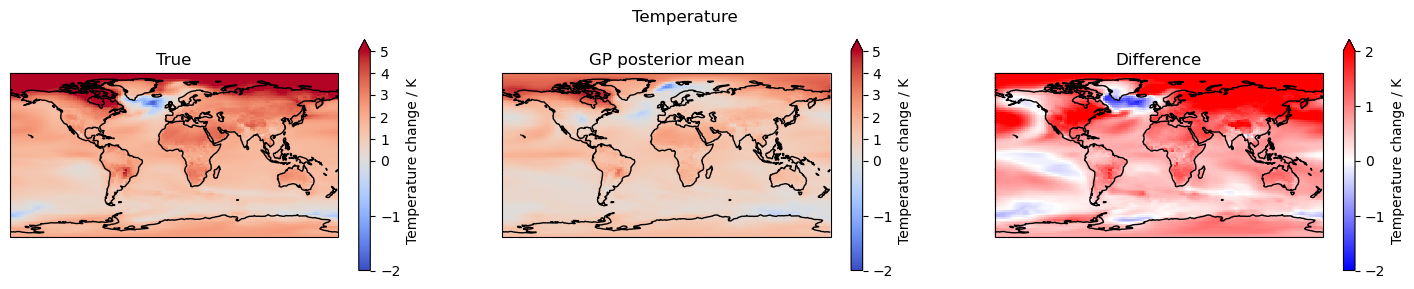

In [15]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [16]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

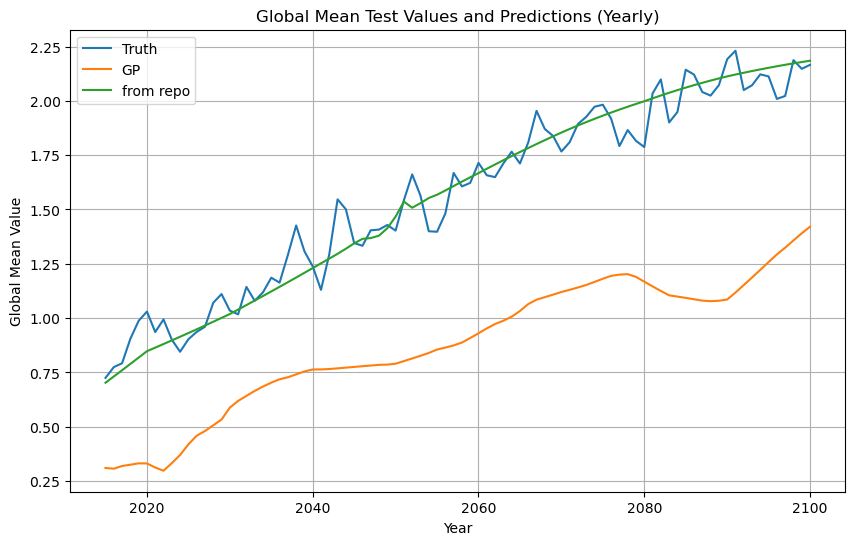

In [18]:
t = xr.open_dataarray('climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(tas_truth).plot(label="Truth")
global_mean(posterior_tas_data).plot(label='GP')
global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparams Tuning

In [8]:
from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from gpflow.kernels import Matern12, Matern32, Matern52, SquaredExponential, RationalQuadratic, Cosine, Periodic, Polynomial, ArcCosine, Exponential
import keras
import math
from gpflow.mean_functions import Constant
from xskillscore import rmse
from ray.tune import CLIReporter

In [9]:
def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

weights = np.cos(np.deg2rad(tas_truth.lat)).expand_dims(lon=144).assign_coords(lon=tas_truth.lon)
    
def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(tas_truth.sel(time=Yearslice).mean('time')).data)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(3)
    return total

In [10]:
def make_feature_extractor(dim_max, activation, input_dim, output_dim, dropout_prob, bnorm=True, dropout=True):
    model = tf.keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    
    dimensions = [dim_max // (2 ** i) for i in range(int(math.log(dim_max, 2)) + 1) if dim_max // (2 ** i) > input_dim]

    for dim in dimensions[::-1]:
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    for dim in dimensions:
        if dim <= output_dim:
            break
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    model.add(keras.layers.Dense(output_dim, activation='linear'))
    model.add(keras.layers.Lambda(lambda x: tf.cast(x, tf.float64)))
        
    return model

In [11]:
def basekernel(kernel_types, active_dim_multiplier, variance=1.0, lengthscales=1.0):
    kernels = {
        'Matern12': Matern12, 'Matern32': Matern32, 'Matern52': Matern52, 'SquaredExponential': SquaredExponential, 'RationalQuadratic': RationalQuadratic, 'Cosine':Cosine, 'Periodic': Periodic,
        'Polynomial': Polynomial, 'ArcCosine': ArcCosine, 'Exponential': Exponential
    }
    dims = [x for x in range(12*active_dim_multiplier)]
    def CO2(kernel):
        active_dims = dims[0:active_dim_multiplier*1]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k

    def CH4(kernel):
        active_dims = dims[1*active_dim_multiplier:active_dim_multiplier*2]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k
        
    def BC(kernel):
        active_dims = dims[2*active_dim_multiplier:active_dim_multiplier*2 + 5*active_dim_multiplier]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k

    def SO2(kernel):
        active_dims = dims[active_dim_multiplier*2 + 5*active_dim_multiplier:]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k
    
    kernel = CO2(kernels[kernel_types[0]]) + CH4(kernels[kernel_types[1]]) + BC(kernels[kernel_types[2]]) + SO2(kernels[kernel_types[3]])

    return kernel

In [12]:
def objective(config, return_pred=False):  # ①
    input_dim = X_train.shape[1]  # Number of features in X
    
    output_dim = config["output_dim"]
    # Feature extractor for deep kernel
    feature_extractor = make_feature_extractor(
        config["dim_max"], config["activation"], input_dim, config["output_dim"], config["dropout_prob"], bnorm=config["bnorm"], dropout=config["dropout"]
    )
    
    # Freeze the neural network layers to make them non-trainable in GPflow's optimization process
    for layer in feature_extractor.layers:
        layer.trainable = True
    
    # Define kernel
    base_kernel = basekernel(
        config["kernel_types"], config["active_dim_multiplier"]
    )
    deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

    mean_function = Constant() # Define Mean function

    optimizer  = tf.keras.optimizers.Adam(learning_rate=config["optimizer_lr"])# Define opt

    model = gpflow.models.GPR(data=(X_train.astype(float), y_train_tas.astype(float)), kernel=deep_kernel, mean_function=mean_function)
    

    # custom optimizer
    @tf.function
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            loss = -model.log_marginal_likelihood()
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss


    # Training
    tolerance, patience = 1e-6, 10  # Define tolerance and patience

    # Initialize variables for early stopping mechanism
    best_loss, patience_counter, max_iterations = float('inf'), 0, 5000
    
    # Training loop
    for iteration in range(max_iterations):  # Number of optimization steps
        loss = optimization_step()
    
        # Early stopping logic
        if best_loss - loss < tolerance:
            patience_counter += 1
        else:
            patience_counter = 0
            best_loss = loss
    
        if patience_counter >= patience:
            print(f"Stopping training after {iteration + 1} iterations due to convergence.")
            break

    # Eval
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
    posterior_std = np.sqrt(standard_posterior_var) * train_tas_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
    posterior_tas_std = np.reshape(posterior_std, [86, 96, 144])
    
    posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
    posterior_tas_std_data = xr.DataArray(posterior_tas_std, dims=tas_truth.dims, coords=tas_truth.coords)

    total_NRMSE = TNRMSE(tas_truth, posterior_tas_data)

    if return_pred:
        return posterior_tas_data, posterior_tas_std_data


    return {'nrmse':total_NRMSE}

In [13]:
# Set the number of samples for HyperOpt to try
num_samples = 50

search_space = {
    "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
    "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52'], 4*['SquaredExponential']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 64]), 
    "output_dim": tune.choice([12, 24, 36, 48, 60]), "optimizer_lr": tune.choice([0.01, 0.001])
}  # ②


algo = HyperOptSearch()

tuner = tune.Tuner(  # ③
    tune.with_resources(
        objective,
        resources={"cpu": 1, "gpu": 1}
    ),
    tune_config=tune.TuneConfig(
        metric="nrmse",
        mode="min",
        num_samples=num_samples,
        search_alg=algo,
    ),
    param_space=search_space,
)

In [72]:
results = tuner.fit()

2024-02-24 22:11:56,195	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
2024-02-24 22:12:08,742	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
2024-02-24 22:12:19,634	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
2024-02-24 22:12:27,924	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
2024-02-24 22:12:40,568	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
2024-02-24 22:13:25,577	INFO tensorboard

In [78]:
best_trial = results.get_best_result(scope='all')
best_trial

Result(
  metrics={'nrmse': 0.355},
  path='/glade/u/home/jklim/ray_results/objective_2024-02-24_22-11-23/objective_9f13b83b_27_activation=sigmoid,active_dim_multiplier=1,bnorm=True,dim_max=256,dropout=True,dropout_prob=0.5000,kernel_ty_2024-02-24_22-23-08',
  filesystem='local',
  checkpoint=None
)

In [94]:
results_df = results.get_dataframe().sort_values(by='nrmse')
results_df

,nrmse,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,config/activation,config/bnorm,config/dropout,config/dropout_prob,config/kernel_types,config/active_dim_multiplier,config/dim_max,config/output_dim,config/optimizer_lr,logdir
26,0.355,1708838679,None,False,1,9f13b83b,2024-02-24_22-24-39,44.603866,44.603866,59609,...,sigmoid,True,True,0.5,"(Matern12, Matern12, Matern12, Matern12)",1,256,36,0.001,9f13b83b
31,0.357,1708838864,None,False,1,81284b11,2024-02-24_22-27-44,11.249746,11.249746,59609,...,tanh,True,True,0.5,"(Matern12, Matern12, Matern12, Matern12)",1,256,60,0.001,81284b11
25,0.382,1708838635,None,False,1,9ff1db8e,2024-02-24_22-23-55,46.679875,46.679875,59609,...,sigmoid,True,True,0.5,"(Matern12, Matern12, Matern12, Matern12)",1,256,60,0.001,9ff1db8e
22,0.391,1708838499,None,False,1,e62b571a,2024-02-24_22-21-39,40.912348,40.912348,59609,...,sigmoid,True,True,0.5,"(Matern12, Matern12, Matern12, Matern12)",1,256,60,0.001,e62b571a
20,0.395,1708838447,None,False,1,04b5a3b5,2024-02-24_22-20-47,41.302693,41.302693,59609,...,sigmoid,True,True,0.5,"(Matern12, Matern12, Matern12, Matern12)",2,256,36,0.001,04b5a3b5
40,0.415,1708839122,None,False,1,a97a45b5,2024-02-24_22-32-02,36.975565,36.975565,59609,...,tanh,True,True,0.5,"(Matern12, Matern12, Matern12, Matern12)",1,64,36,0.001,a97a45b5
38,0.420,1708839072,None,False,1,a281195c,2024-02-24_22-31-12,10.960130,10.960130,59609,...,tanh,True,True,0.5,"(Matern12, Matern12, Matern12, Matern12)",1,256,60,0.001,a281195c
30,0.451,1708838853,None,False,1,83ae8f10,2024-02-24_22-27-33,46.053454,46.053454,59609,...,sigmoid,True,True,0.5,"(Matern12, Matern12, Matern12, Matern12)",1,256,36,0.001,83ae8f10
19,0.451,1708838405,None,False,1,ce8b4a0c,2024-02-24_22-20-05,37.702508,37.702508,59609,...,sigmoid,False,True,0.5,"(Matern32, Matern32, Matern32, Matern32)",1,128,60,0.001,ce8b4a0c
21,0.504,1708838458,None,False,1,5297448e,2024-02-24_22-20-58,10.881932,10.881932,59609,...,sigmoid,False,True,0.5,"(Matern32, Matern32, Matern32, Matern32)",2,128,36,0.010,5297448e


In [83]:
results_df[results_df['nrmse'] == 0.355].values

array([[0.355, 1708838679, None, False, 1, '9f13b83b',
        '2024-02-24_22-24-39', 44.6038658618927, 44.6038658618927, 59609,
        'casper19', '128.117.208.133', 44.6038658618927, 1, 'sigmoid',
        True, True, 0.5,
        ('Matern12', 'Matern12', 'Matern12', 'Matern12'), 1, 256, 36,
        0.001, '9f13b83b']], dtype=object)

In [95]:
best_config = best_trial.config
best_config

{'activation': 'sigmoid',
 'bnorm': True,
 'dropout': True,
 'dropout_prob': 0.5,
 'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12'),
 'active_dim_multiplier': 1,
 'dim_max': 256,
 'output_dim': 36,
 'optimizer_lr': 0.001}

In [14]:
mean_best, std_best = objective({'activation': 'sigmoid',
 'bnorm': True,
 'dropout': True,
 'dropout_prob': 0.5,
 'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12'),
 'active_dim_multiplier': 1,
 'dim_max': 256,
 'output_dim': 36,
 'optimizer_lr': 0.001}, return_pred=True)

2024-02-27 01:12:30.237802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 826 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0
2024-02-27 01:12:42.539192: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xf5f04d0
2024-02-27 01:12:42.677235: I external/local_xla/xla/service/service.cc:168] XLA service 0x14e147930ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-27 01:12:42.677264: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-02-27 01:12:42.684755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-27 01:12:42.718396: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] L

Stopping training after 2804 iterations due to convergence.


[Text(0.5, 1.0, 'Difference')]

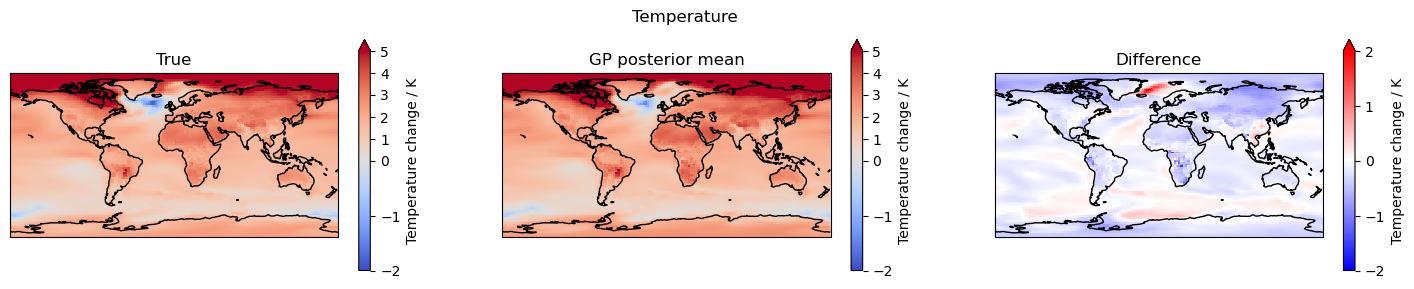

In [15]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mean_best.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - mean_best
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

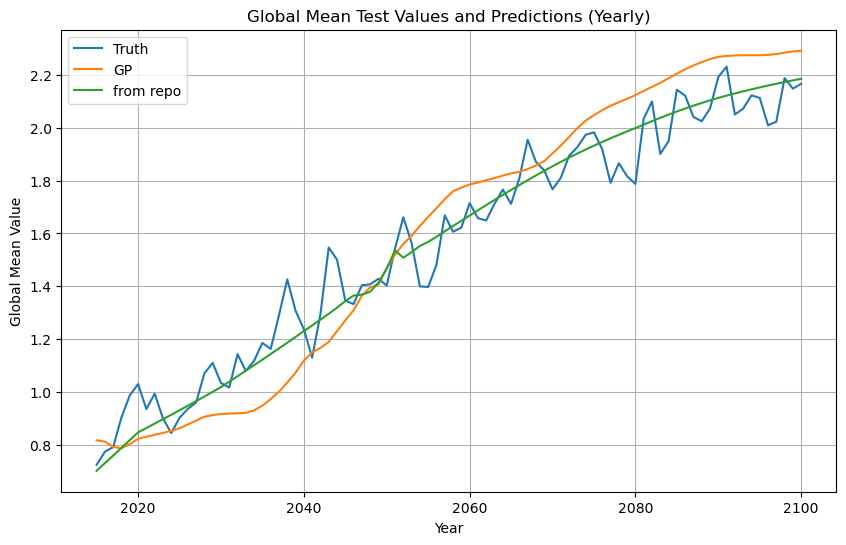

In [16]:
t = xr.open_dataarray('climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(tas_truth).plot(label="Truth")
global_mean(mean_best).plot(label='GP')
global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
mean_best.to_netcdf('model/final-gp-best-1-model-mean-tas.nc')
std_best.to_netcdf('model/final-gp-best-1-model-std-tas.nc')

In [22]:
def run_tuner(search_space, num_samples=50):
    algo = HyperOptSearch()
    
    tuner = tune.Tuner(  # ③
        tune.with_resources(
            objective,
            resources={"cpu": 12, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="nrmse",
            mode="min",
            num_samples=num_samples,
            search_alg=algo,
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    return results

In [101]:
search_space = {
        "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
        "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 512]), 
        "output_dim": tune.choice([36, 48, 60, 72, 84]), "optimizer_lr": tune.choice([0.01, 0.001, 0.0001])
    }  # ②

run_tuner(search_space)

2024-02-24 23:17:16,312	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
2024-02-24 23:18:16,380	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
2024-02-24 23:18:28,794	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
2024-02-24 23:18:42,107	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
2024-02-24 23:18:57,261	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
2024-02-24 23:20:00,874	INFO tensorboard

ResultGrid<[
  Result(
    metrics={'nrmse': 2.271},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-24_23-16-44/objective_8332303c_1_activation=relu,active_dim_multiplier=1,bnorm=True,dim_max=128,dropout=True,dropout_prob=0.5000,kernel_types=_2024-02-24_23-16-45',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 0.563},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-24_23-16-44/objective_215bee35_2_activation=sigmoid,active_dim_multiplier=2,bnorm=False,dim_max=256,dropout=True,dropout_prob=0.5000,kernel_ty_2024-02-24_23-16-57',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 3.508},
    path='/glade/u/home/jklim/ray_results/objective_2024-02-24_23-16-44/objective_ad36fdb5_3_activation=tanh,active_dim_multiplier=2,bnorm=True,dim_max=512,dropout=True,dropout_prob=0.5000,kernel_types=_2024-02-24_23-17-16',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'nrmse': 1.696},
    p

In [14]:
temp = pd.read_csv('model configs and dfs/grid_search_1_tas.csv')

In [17]:
temp.sort_values(by='nrmse').iloc[0]

Unnamed: 0                                                                    26
nrmse                                                                      0.355
timestamp                                                             1708838679
checkpoint_dir_name                                                          NaN
done                                                                       False
training_iteration                                                             1
trial_id                                                                9f13b83b
date                                                         2024-02-24_22-24-39
time_this_iter_s                                                       44.603866
time_total_s                                                           44.603866
pid                                                                        59609
hostname                                                                casper19
node_ip                     

In [18]:
t = {
    "activation": "sigmoid", "bnorm": True, "dropout": True, 'dropout_prob': 0.5,
        "kernel_types": 4*['Matern12'], "active_dim_multiplier":1, "dim_max": 256, 
        "output_dim": 36, "optimizer_lr": 0.001
}
mean_best, _ = objective(t, return_pred=True)

2024-02-25 01:19:59.556542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79084 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2024-02-25 01:19:59.558349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79084 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-02-25 01:20:06.877856: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x4b0dec0
2024-02-25 01:20:06.947305: I external/local_xla/xla/service/service.cc:168] XLA service 0x11bf2770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-25 01:20:06.947356: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-25 01:20:0

Stopping training after 2909 iterations due to convergence.


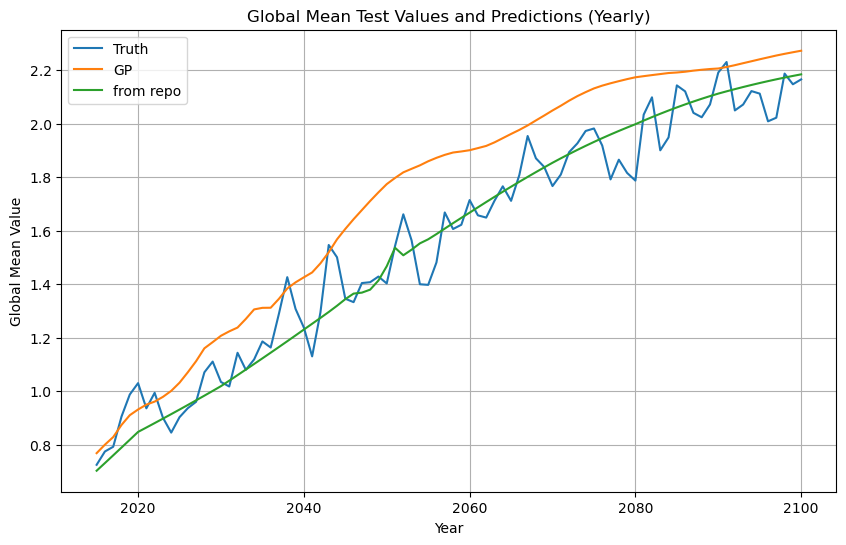

In [19]:
t = xr.open_dataarray('climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(tas_truth).plot(label="Truth")
global_mean(mean_best).plot(label='GP')
global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

[Text(0.5, 1.0, 'Difference')]

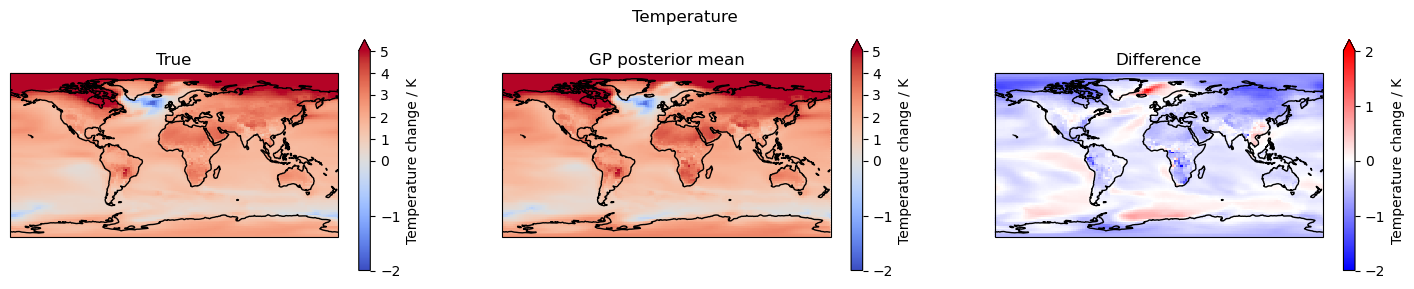

In [20]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mean_best.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - mean_best
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [ ]:
search_space = {
        "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
        "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 512]), 
        "output_dim": tune.choice([36, 48, 60, 72, 84]), "optimizer_lr": tune.choice([0.01, 0.001, 0.0001])
    }  # ②

run_tuner(search_space)

(raylet) Warning: The actor ImplicitFunc is very large (35 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(pid=256114) 2024-02-25 01:23:10.721174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=256114) 2024-02-25 01:23:10.721382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=256114) 2024-02-25 01:23:10.722531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=256114) 2024-02-25 01:23:12.536222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=257032) 2024-02-25 01:23:24.809603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN wh

(objective pid=257032) Stopping training after 389 iterations due to convergence.


2024-02-25 01:25:34,639	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=257032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1441a54a7f70> and will run it as-is.
(objective pid=257032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=257032) Cause: Unknown node type <gast.gast.Import object at 0x14408048d310>
(objective pid=257032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=257032) Stopping training after 2451 iterations due to convergence.


2024-02-25 01:26:26,983	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=257032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1440801f4f70> and will run it as-is.
(objective pid=257032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=257032) Cause: Unknown node type <gast.gast.Import object at 0x144024f51130>
(objective pid=257032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 01:26:31,968	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=256114) WARNING:tensorflow:AutoGraph could not t

(objective pid=256114) Stopping training after 425 iterations due to convergence.


2024-02-25 01:26:52,940	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=256114) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15159a290430> and will run it as-is.
(objective pid=256114) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=256114) Cause: Unknown node type <gast.gast.Import object at 0x15159a333550>
(objective pid=256114) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-02-25 01:27:03,607	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=256114) Stopping training after 66 iterations due to convergence.


(objective pid=256114) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15141070baf0> and will run it as-is.
(objective pid=256114) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=256114) Cause: Unknown node type <gast.gast.Import object at 0x15159a322fa0>
(objective pid=256114) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=256114) Stopping training after 661 iterations due to convergence.


2024-02-25 01:27:21,550	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}
(objective pid=256114) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1514701cc8b0> and will run it as-is.
(objective pid=256114) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=256114) Cause: Unknown node type <gast.gast.Import object at 0x1513e9cdd310>
(objective pid=256114) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=257032) Stopping training after 3123 iterations due to convergence.


2024-02-25 01:27:33,109	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=257032) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x144084683e50> and will run it as-is.
(objective pid=257032) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=257032) Cause: Unknown node type <gast.gast.Import object at 0x144024a50df0>
(objective pid=257032) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=256114) Stopping training after 2653 iterations due to convergence.


2024-02-25 01:28:09,667	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=256114) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1514701cc0d0> and will run it as-is.
(objective pid=256114) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=256114) Cause: Unknown node type <gast.gast.Import object at 0x1514103b5af0>
(objective pid=256114) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
